# Momentum and vorticity budgets in the two-layer SWM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:42437' processes=4 threads=16, memory=270.45 GB>

$\large \text{Stats and time series}$ 

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Layer_SWM/2L/"

ds_stat = xr.open_dataset(ppdir+"ocean.stats.nc")

print(ds_stat)

<xarray.Dataset>
Dimensions:        (Interface: 3, Layer: 2, Time: 11)
Coordinates:
  * Layer          (Layer) float64 1.027e+03 1.028e+03
  * Interface      (Interface) float64 1.027e+03 1.028e+03 1.028e+03
  * Time           (Time) timedelta64[ns] 7300 days 7310 days ... 7400 days
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  ./ocean.stats.nc


In [5]:
rho = ds_stat['Layer'].values
print(rho)

[1027.35      1027.9087526]


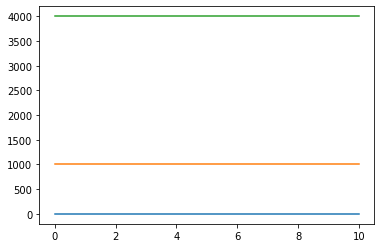

In [6]:
plt.plot(ds_stat['H0'])

Text(0, 0.5, 'Potential Energy (J)')

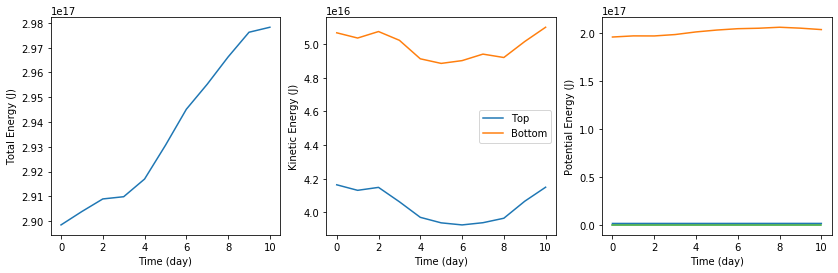

In [7]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(ds_stat['En'])
plt.xlabel('Time (day)')
plt.ylabel('Total Energy (J)')

plt.subplot(1,3,2)
plt.plot(ds_stat['KE'])
plt.xlabel('Time (day)')
plt.ylabel('Kinetic Energy (J)')
plt.legend(['Top', 'Bottom'])

plt.subplot(1,3,3)
plt.plot(ds_stat['APE'])
plt.xlabel('Time (day)')
plt.ylabel('Potential Energy (J)')
#plt.legend(['Top', 'Bottom'])

# Momentum budget

First look at all terms in the momentum budget at different times. All terms in the momentum budget are represented in the equation below. Some of the terms are not relevant for a stacked shallow water model.

\begin{equation}
\left[ \frac{\partial \mathbf{u}}{\partial t} \right]_{s} =
- \left[ \frac{f + \zeta}{h} \right] \hat{\mathbf{z}} \wedge (h \, \mathbf{u}) 
- w^{(\dot{s})} \, \frac{\partial \mathbf{u}}{\partial z}
-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]
- \nabla_{s} K 
+ \boldsymbol{F}^{({\mbox{\tiny horz frict}})}
+ \boldsymbol{F}^{({\mbox{\tiny vert frict}})}
+ \rho^{-1} \, \boldsymbol{\tau}^{(\mbox{\tiny bound})} 
\label{eq:continuous-velocity-equation}
\end{equation}
where we have 
\begin{alignat}{2}
\boldsymbol{v} &= \boldsymbol{u} + \hat{\boldsymbol{z}} \, w
= \hat{\boldsymbol{x}} \, u  +  \hat{\boldsymbol{y}} \, v
 + \hat{\boldsymbol{z}} \, w
&\mbox{velocity}
\\
\nabla_{s} &= 
\hat{\boldsymbol{x}} \left[ \frac{\partial}{\partial x} \right]_{s}
+
\hat{\boldsymbol{y}} \left[ \frac{\partial}{\partial y} \right]_{s}
&\mbox{horizontal gradient on $s$-surface}
\\
w^{(\dot{s})} &= \frac{\partial z}{\partial s} \, \frac{\mathrm{D}s}{\mathrm{D}t}
&\mbox{dia-surface velocity used for remapping}
\\
\zeta &= \left[ \frac{\partial v}{\partial x} \right]_{s} 
        -\left[ \frac{\partial u}{\partial y} \right]_{s} 
&\mbox{$s$-coordinate vertical vorticity}
\\
\Phi &= g \, z \qquad 
&\mbox{geopotential (more complex when have tides)}
\\
-\rho^{-1} \, \nabla_{z}p  &= 
-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]
\qquad &\mbox{horizontal pressure acceleration} 
\\
K &= \frac{u^{2} + v^{2}}{2}  \qquad 
&\mbox{horizontal kinetic energy per mass}
\\
\boldsymbol{F}^{({\mbox{\tiny horz frict}})} &= 
\mbox{horiz friction from horz shear} &\mbox{Laplacian or biharmonic}
\\
\boldsymbol{F}^{({\mbox{\tiny vert frict}})} &= 
\mbox{vert friction from vertical shear} &\mbox{Laplacian}
\\
\rho^{-1} \, \boldsymbol{\tau}^{(\mbox{\tiny bound})} &=
\mbox{boundary frictional acceleration} &\mbox{wind, bottom drag, etc.}
\end{alignat}

In [4]:
ds_mom = xr.open_dataset(ppdir + "mom_avg.nc")
ds_prog = xr.open_dataset(ppdir + "prog.nc")
ds_con = xr.open_dataset(ppdir + "cont__0021_006.nc")
ds_bt_mom = xr.open_dataset(ppdir + "bt_mom__0021_006.nc")
#ds_ene = xr.open_dataset(ppdir + "energy__0021_006.nc")

dsgrid = xr.open_dataset(ppdir + "ocean_month.nc")

ds = xr.merge([ds_mom, ds_prog, ds_con, ds_bt_mom, dsgrid])

In [5]:
#ds = ds.chunk({'Time': 1})

ds = xr.open_dataset(ppdir + "mom.nc")
ds

<xarray.Dataset>
Dimensions:     (Time: 365, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * xq          (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yh          (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * zl          (zl) float64 1.027e+03 1.028e+03
  * Time        (Time) object 0001-01-11 00:00:00 ... 0010-12-30 00:00:00
  * xh          (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq          (yq) float64 4.0 8.0 12.0 16.0 20.0 ... 788.0 792.0 796.0 800.0
Data variables:
    dudt        (Time, zl, yh, xq) float32 ...
    dvdt        (Time, zl, yq, xh) float32 ...
    CAu         (Time, zl, yh, xq) float32 ...
    CAv         (Time, zl, yq, xh) float32 ...
    PFu         (Time, zl, yh, xq) float32 ...
    PFv         (Time, zl, yq, xh) float32 ...
    du_dt_visc  (Time, zl, yh, xq) float32 ...
    dv_dt_visc  (Time, zl, yq, xh) float32 ...
    diffu       (Time, zl, yh, xq) float32 ...
    diffv       (T

$\large \text{Layerwise Budgets}$

We first look at layerwise momentum and voticity budgets. Left and right panels are for the top and bottom layers, respectively.

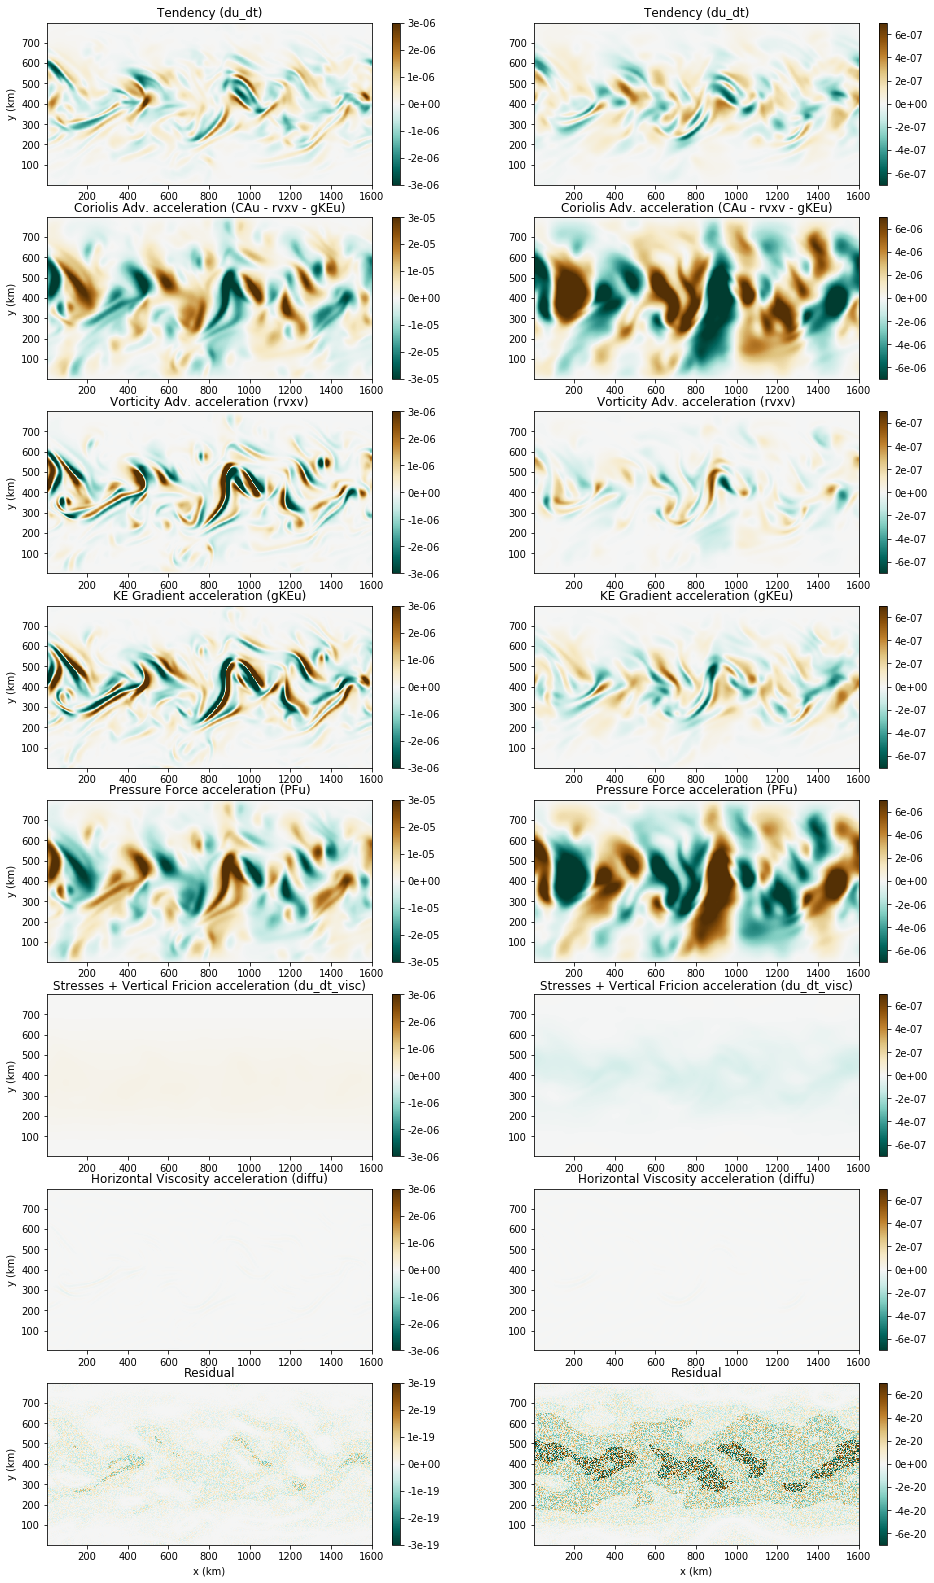

In [7]:
# Zonal Momentum budget
idx = 5
plt.figure(figsize=(16,28))
max_r = [3.e-6, 7.e-7]

for i in range(0,2):
    plt.subplot(8,2, i+1)
    plt.pcolormesh(ds['xq'], ds['yh'], ds['dudt'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (du_dt)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+3)
    plt.pcolor(ds['xq'], ds['yh'], (ds['CAu']-ds['rvxv']-ds['gKEu']).isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Coriolis Adv. acceleration (CAu - rvxv - gKEu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+5)
    plt.pcolor(ds['xq'], ds['yh'], (ds['rvxv']).isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Vorticity Adv. acceleration (rvxv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(8,2, i+7)
    plt.pcolor(ds['xq'], ds['yh'], (ds['gKEu']).isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('KE Gradient acceleration (gKEu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+9)
    plt.pcolor(ds['xq'], ds['yh'], ds['PFu'].isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+11)
    plt.pcolor(ds['xq'], ds['yh'], ds['du_dt_visc'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (du_dt_visc)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+13)
    plt.pcolor(ds['xq'], ds['yh'], ds['diffu'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+15)
    plt.pcolor(ds['xq'], ds['yh'], (ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc']).isel(Time=idx, zl=i)
               - ds['u_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-13*max_r[i], vmax = 1e-13*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

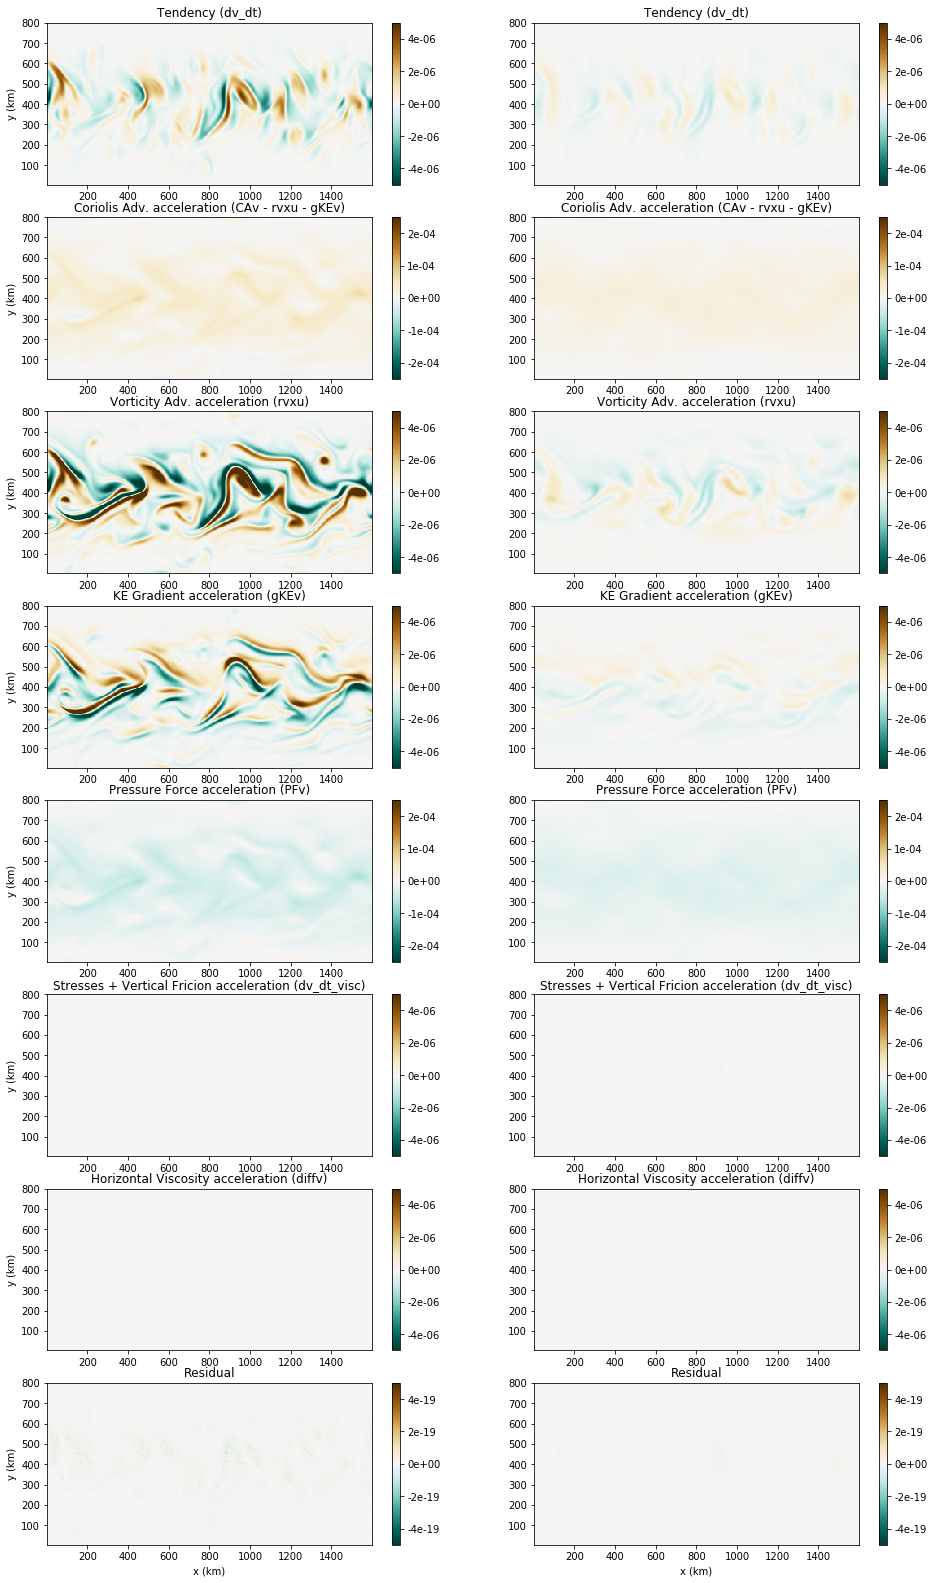

In [8]:
# Meridional Momentum Budget
idx = 5
plt.figure(figsize=(16,28))
max_r = [5.e-6, 5.e-6]

for i in range(0,2):
    plt.subplot(8,2, i+1)
    plt.pcolormesh(ds['xh'], ds['yq'], ds['dvdt'].isel(Time=idx, zl=i), vmin = -max_r[i], 
                   vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (dv_dt)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+3)
    plt.pcolor(ds['xh'], ds['yq'], (ds['CAv']-ds['rvxu']-ds['gKEv']).isel(Time=idx, zl=i), vmin = -5e1*max_r[i], 
               vmax = 5e1*max_r[i], cmap='BrBG_r')
    plt.title('Coriolis Adv. acceleration (CAv - rvxu - gKEv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+5)
    plt.pcolor(ds['xh'], ds['yq'], (ds['rvxu']).isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Vorticity Adv. acceleration (rvxu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(8,2, i+7)
    plt.pcolor(ds['xh'], ds['yq'], (ds['gKEv']).isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('KE Gradient acceleration (gKEv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(8,2, i+9)
    plt.pcolor(ds['xh'], ds['yq'], ds['PFv'].isel(Time=idx, zl=i), vmin = -5e1*max_r[i], vmax = 5e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+11)
    plt.pcolor(ds['xh'], ds['yq'], ds['dv_dt_visc'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (dv_dt_visc)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+13)
    plt.pcolor(ds['xh'], ds['yq'], ds['diffv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(8,2, i+15)
    plt.pcolor(ds['xh'], ds['yq'], (ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc']).isel(Time=idx, zl=i)
               - ds['v_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-13*max_r[i], vmax = 1e-13*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

In [9]:
# Vorticity Budget

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

dzeta_dt = ( - grid.diff(ds['dudt']/ds['dyCu'], 'Y', boundary='fill')
            + grid.diff(ds['dvdt']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_CA = ( - grid.diff(ds['CAu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['CAv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_PF = ( - grid.diff(ds['PFu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['PFv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_RV = ( - grid.diff(ds['rvxv']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['rvxu']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_KE = ( - grid.diff(ds['gKEu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['gKEv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_diff = ( - grid.diff(ds['diffu']/ds['dyCu'], 'Y', boundary='fill')
             + grid.diff(ds['diffv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_visc = ( - grid.diff(ds['du_dt_visc']/ds['dyCu'], 'Y', boundary='fill')
             + grid.diff(ds['dv_dt_visc']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_BT_accel = ( - grid.diff(ds['u_BT_accel']/ds['dyCu'], 'Y', boundary='fill')
                 + grid.diff(ds['v_BT_accel']/ds['dxCv'], 'X', boundary='fill') ) 

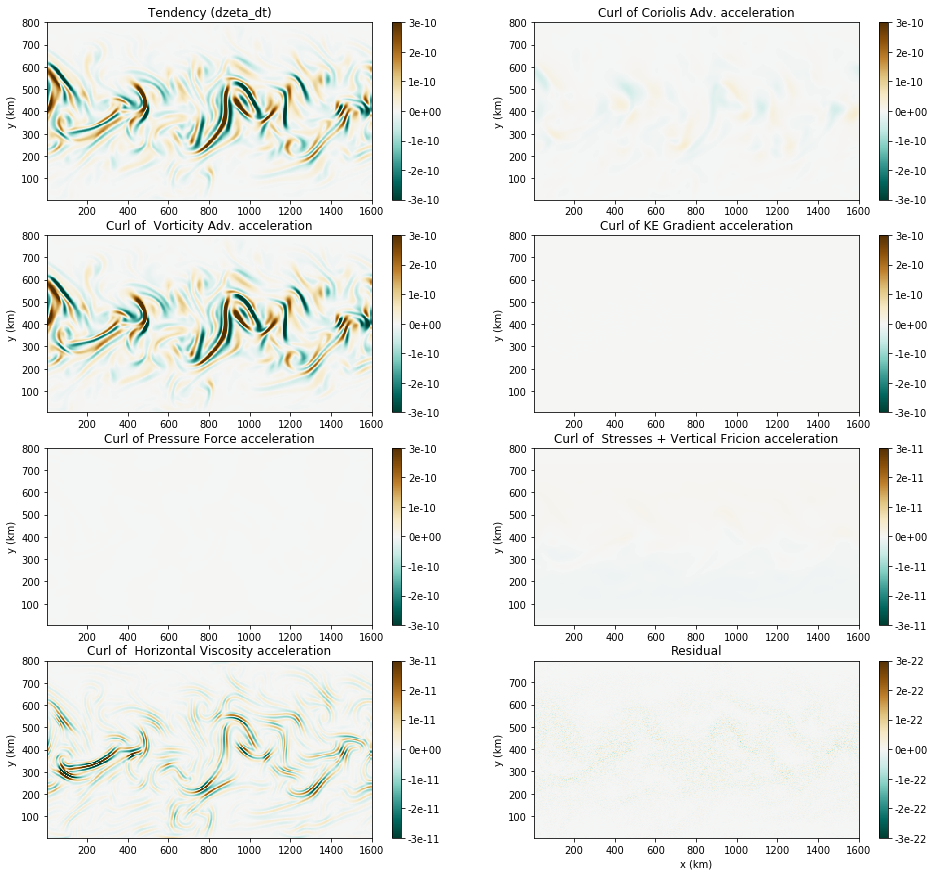

In [10]:
idx = 5 
plt.figure(figsize=(16,15))
max_r = [30.e-11, 30.e-11]

for i in range(0,1):
    plt.subplot(4,2, i+1)
    plt.pcolormesh(ds['xq'], ds['yq'], dzeta_dt.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (dzeta_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+2)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_CA - zeta_RV - zeta_KE).isel(Time=idx, zl=i), vmin = -1.e0*max_r[i], 
             vmax = 1.e0*max_r[i], cmap='BrBG_r')
    plt.title('Curl of Coriolis Adv. acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+3)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_RV).isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Curl of  Vorticity Adv. acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(4,2, i+4)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_KE).isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Curl of KE Gradient acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+5)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_PF +zeta_BT_accel).isel(Time=idx, zl=i), vmin = -1.e0*max_r[i], 
             vmax = 1.e0*max_r[i], cmap='BrBG_r')
    plt.title('Curl of Pressure Force acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+6)
    plt.pcolor(ds['xq'], ds['yq'], zeta_visc.isel(Time=idx, zl=i), vmin = -1e-1*max_r[i], 
             vmax = 1e-1*max_r[i], cmap='BrBG_r')
    plt.title('Curl of  Stresses + Vertical Fricion acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+7)
    plt.pcolor(ds['xq'], ds['yq'], zeta_diff.isel(Time=idx, zl=i), vmin = -1e-1*max_r[i], 
             vmax = 1e-1*max_r[i], cmap='BrBG_r')
    plt.title('Curl of  Horizontal Viscosity acceleration')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(4,2, i+8)
    plt.pcolor(ds['xq'], ds['yh'], (dzeta_dt-zeta_CA-zeta_PF-zeta_diff-zeta_visc).isel(Time=idx, zl=i)
               - zeta_BT_accel.isel(Time = idx, zl=i), vmin = -1e-12*max_r[i], vmax = 1e-12*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

$\large \text{Barotropic momentum and vorticity budgets}$

The barotropic velocity tendency term is given as,

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    =
    \left[ \sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}
    +
    \sum_{k} (h_{k}/H) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation} 

Since MOM6 uses vector-invariant form the governing equations, calculus manipulations may not agree with the numerics. Therefore, we compute barotropic velocity tendency online and use this compute the contribution due to the first term on the RHS.

\begin{equation}
\sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}
 =
  \frac{\overline{u}(\tau + \Delta \tau)
          - \overline{u}(\tau)}{\Delta \tau}
 -
 \sum_{k} (h_{k}/H) \, \partial_{t} \boldsymbol{u}_{k},
\end{equation}

If the variation in the total depth H is small, then we can use the following approaximation,

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    \approx
    \frac{1}{H}\left[\sum_{k} \partial_{t} (h_{k}) \, \boldsymbol{u}_{k}
    +
    \sum_{k} (h_{k}) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation}

We check if the relationship holds good. The figure below shows that the most of the contribution in the barotropic velocity tendemcy term is due to $\sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}$ and the thickness tendency term makes little difference. Also, the assumption in the last equation shown above makes the residual larger instead. Therefore, it is better to use the following

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    \approx
    \frac{1}{H}\left[
    \sum_{k} (h_{k}) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation}

The depth-averaged velocity is given by 
\begin{equation}
  \overline{\zeta} = 
  \frac{ \sum_{k} h_{k} \, \zeta_{k}}{\sum_{k} h_{k}}
  =
  \sum_{k} (h_{k}/H) \, \zeta_{k}.
\label{eq:barotropic-vorticity}
\end{equation}

Similar to the method adopted for the depth-averaged vorticity, we can write the time derivative of the depth averaged vorticity as 
\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \zeta_{k}
    \right]
    =
    \left[ \sum_{k} \partial_{t} (h_{k}/H) \, \zeta_{k}
    +
    \sum_{k} (h_{k}/H) \, \partial_{t} \zeta_{k}
    \right].
\label{eq:time-derivative-vorticity-barotropic}
\end{equation} 

In [6]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

hdudt = (grid.interp(ds['h'],'X')*ds['dudt']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
hdvdt = (grid.interp(ds['h'],'Y',boundary='fill')*ds['dvdt']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

udhdt = (ds['u']*grid.interp(ds['dhdt'],'X')).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
vdhdt = (ds['v']*grid.interp(ds['dhdt'],'Y',boundary='fill')).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

CAu = (grid.interp(ds['h'],'X')*ds['CAu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
CAv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['CAv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

RVu = (grid.interp(ds['h'],'X')*ds['rvxv']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
RVv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['rvxu']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

gKEu = (grid.interp(ds['h'],'X')*ds['gKEu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
gKEv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['gKEv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

PFu = (grid.interp(ds['h'],'X')*ds['PFu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
PFv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['PFv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

diffu = (grid.interp(ds['h'],'X')*ds['diffu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
diffv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['diffv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

visc_u = (grid.interp(ds['h'],'X')*ds['du_dt_visc']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
visc_v = (grid.interp(ds['h'],'Y',boundary='fill')*ds['dv_dt_visc']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

u_BT_accel = (grid.interp(ds['h'],'X')*ds['u_BT_accel']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
v_BT_accel = (grid.interp(ds['h'],'Y',boundary='fill')*ds['v_BT_accel']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

KeyError: 'h'

Text(0.5, 0, 'x (km)')

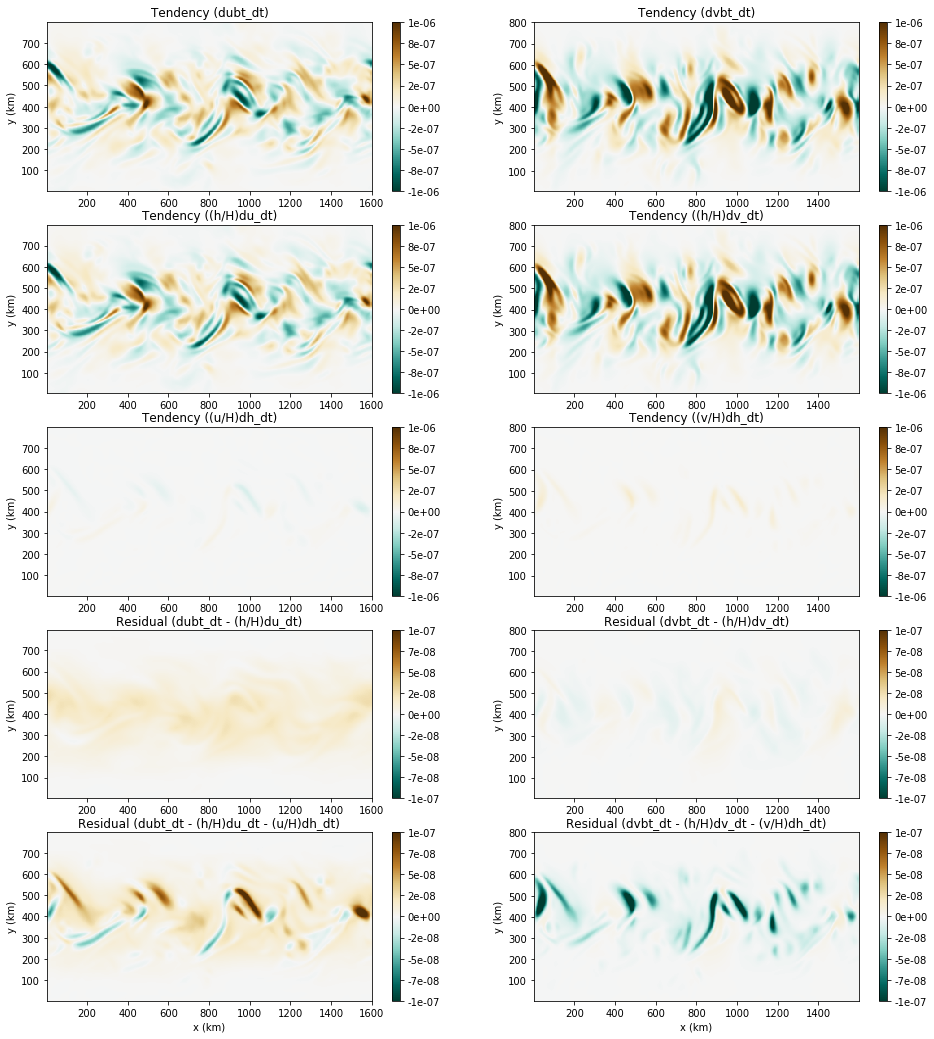

In [12]:
# Compare tendency terms
idx = 5

i = 0
plt.figure(figsize=(16,18))
max_r = [1.e-6, 1.e-6]

plt.subplot(5,2,1)
plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dubt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,2)
plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvbt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,3)
plt.pcolormesh(ds['xq'], ds['yh'], hdudt.isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,4)
plt.pcolormesh(ds['xh'], ds['yq'], hdvdt.isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,5)
plt.pcolormesh(ds['xq'], ds['yh'], (udhdt+0*hdudt).isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((u/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,6)
plt.pcolormesh(ds['xh'], ds['yq'], (vdhdt+0*hdvdt).isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((v/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,7)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['ubt_dt']-0*udhdt-hdudt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dubt_dt - (h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,8)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['vbt_dt']-0*vdhdt-hdvdt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dvbt_dt - (h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,9)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['ubt_dt']-udhdt-hdudt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dubt_dt - (h/H)du_dt - (u/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

plt.subplot(5,2,10)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['vbt_dt']-vdhdt-hdvdt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dvbt_dt - (h/H)dv_dt - (v/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

Text(0, 0.5, 'y (km)')

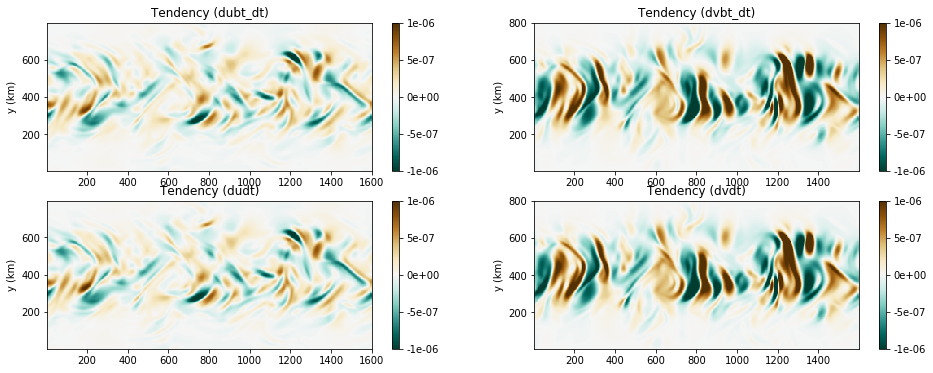

In [10]:
idx = 360

i = 0
plt.figure(figsize=(16,6))
max_r = [1.e-6, 1.e-6]

plt.subplot(2,2,1)
plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dubt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(2,2,2)
plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvbt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(2,2,3)
plt.pcolormesh(ds['xq'], ds['yh'], ds['dudt'].isel(Time=idx,zl=0)*0.25 + ds['dudt'].isel(Time=idx,zl=1)*0.75,
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dudt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(2,2,4)
plt.pcolormesh(ds['xh'], ds['yq'], ds['dvdt'].isel(Time=idx,zl=0)*0.25 + ds['dvdt'].isel(Time=idx,zl=1)*0.75, 
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvdt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

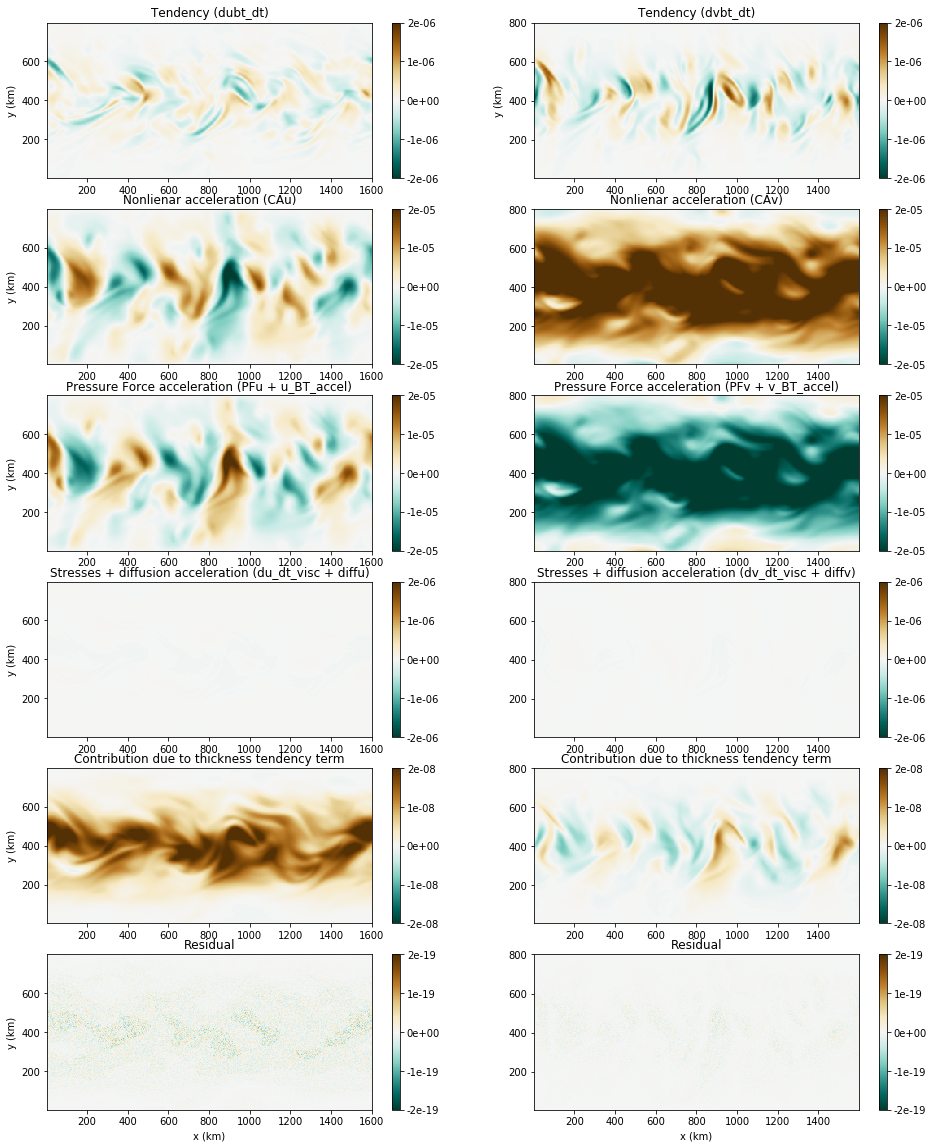

In [13]:
# Barotropic momentum budget
idx = 5 
plt.figure(figsize=(16,20))
max_r = [2.e-6, 2.e-6]

for i in range(0,1):
    plt.subplot(6,2, i+1)
    plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (dubt_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+3)
    plt.pcolor(ds['xq'], ds['yh'], (CAu).isel(Time=idx), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Nonlienar acceleration (CAu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+5)
    plt.pcolor(ds['xq'], ds['yh'], (PFu+u_BT_accel).isel(Time=idx), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFu + u_BT_accel)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+7)
    plt.pcolor(ds['xq'], ds['yh'], (visc_u + diffu).isel(Time=idx), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + diffusion acceleration (du_dt_visc + diffu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(6,2, i+9)
    plt.pcolor(ds['xq'], ds['yh'], (ds['ubt_dt'] - hdudt).isel(Time=idx), vmin = -1e-2*max_r[i], 
             vmax = 1e-2*max_r[i], cmap='BrBG_r')
    plt.title('Contribution due to thickness tendency term')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+11)
    plt.pcolor(ds['xq'], ds['yh'], (hdudt-CAu-PFu-diffu-visc_u).isel(Time=idx)
               - u_BT_accel.isel(Time = idx), vmin = -1e-13*max_r[i], vmax = 1e-13*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
for i in range(1,2):
    plt.subplot(6,2, i+1)
    plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (dvbt_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+3)
    plt.pcolor(ds['xh'], ds['yq'], (CAv).isel(Time=idx), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Nonlienar acceleration (CAv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+5)
    plt.pcolor(ds['xh'], ds['yq'], (PFv+v_BT_accel).isel(Time=idx), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFv + v_BT_accel)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+7)
    plt.pcolor(ds['xh'], ds['yq'], (visc_v + diffv).isel(Time=idx), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + diffusion acceleration (dv_dt_visc + diffv)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(6,2, i+9)
    plt.pcolor(ds['xh'], ds['yq'], (ds['vbt_dt'] - hdvdt).isel(Time=idx), vmin = -1e-2*max_r[i], 
             vmax = 1e-2*max_r[i], cmap='BrBG_r')
    plt.title('Contribution due to thickness tendency term')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+11)
    plt.pcolor(ds['xh'], ds['yq'], (hdvdt-CAv-PFv-diffv-visc_v).isel(Time=idx)
               - v_BT_accel.isel(Time = idx), vmin = -1e-13*max_r[i], vmax = 1e-13*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

In [15]:
# Compute barotropic vorticity budget terms

h_zeta = grid.interp(grid.interp(ds['h'],'X'),'Y',boundary='fill')

hdzeta_dt = (h_zeta*dzeta_dt).sum('zl')/h_zeta.sum('zl')

hzeta_CA = (h_zeta*zeta_CA).sum('zl')/h_zeta.sum('zl')

hzeta_diff = (h_zeta*zeta_diff).sum('zl')/h_zeta.sum('zl')

hzeta_res = (h_zeta*(zeta_PF + zeta_visc + zeta_BT_accel)).sum('zl')/h_zeta.sum('zl')

zeta = ( - grid.diff(ds['u']/ds['dyCu'], 'Y', boundary='fill')
        + grid.diff(ds['v']/ds['dxCv'], 'X', boundary='fill') )

zetadh_dt = (zeta*grid.interp(grid.interp(ds['dhdt'],'X'),'Y',boundary='fill')).sum('zl')/h_zeta.sum('zl')

Text(0.5, 0, 'x (km)')

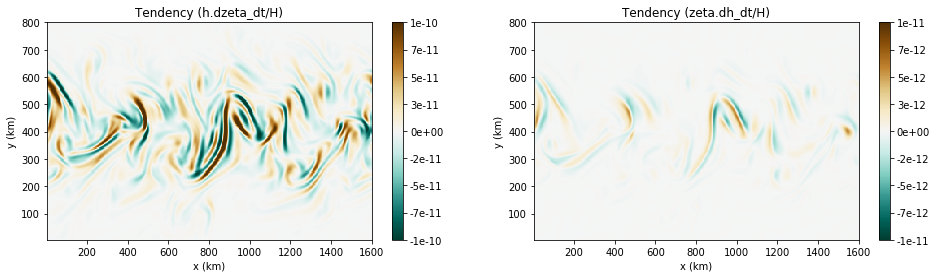

In [19]:
# Compare hdzetadt and zetadhdt terms
idx = 5 
plt.figure(figsize=(16,4))
max_r = 10.e-11

plt.subplot(1,2,1)
plt.pcolormesh(ds['xq'], ds['yq'], hdzeta_dt.isel(Time=idx), vmin = -max_r, vmax = max_r, cmap='BrBG_r')
plt.title('Tendency (h.dzeta_dt/H)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')
plt.xlabel('x (km)')

plt.subplot(1,2,2)
plt.pcolormesh(ds['xq'], ds['yq'], zetadh_dt.isel(Time=idx), vmin = -0.1*max_r, vmax = 0.1*max_r, cmap='BrBG_r')
plt.title('Tendency (zeta.dh_dt/H)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')
plt.xlabel('x (km)')

$\large \text{Spatially averaged momentum budget}$

Text(0.5, 0, 'Time (day)')

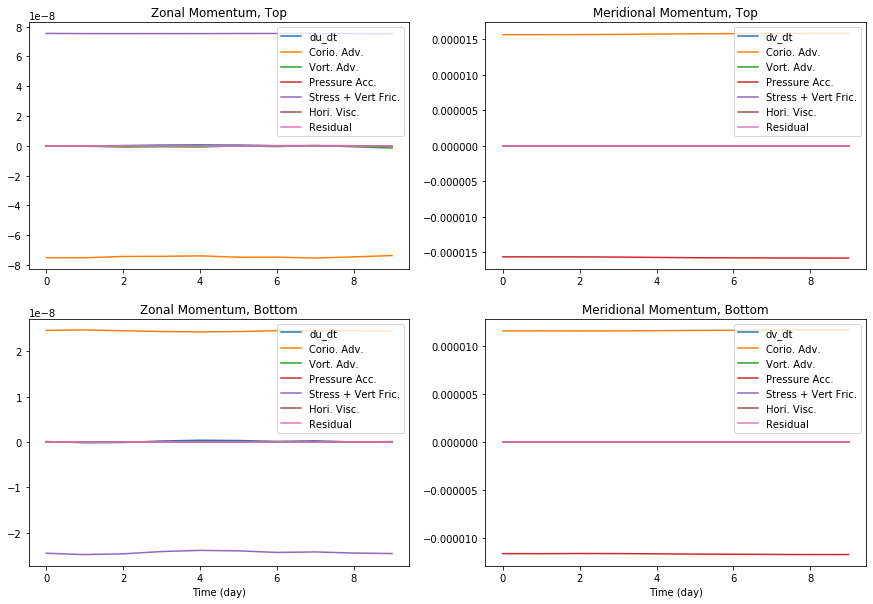

In [29]:
idx = 5 

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(ds['dudt'].mean(['xq','yh']).isel(zl=0), label='du_dt')
plt.plot((ds['CAu']-ds['rvxv']).mean(['xq','yh']).isel(zl=0), label='Corio. Adv.')
plt.plot(ds['rvxv'].mean(['xq','yh']).isel(zl=0), label='Vort. Adv.')
plt.plot(ds['PFu'].mean(['xq','yh']).isel(zl=0), label='Pressure Acc.')
plt.plot(ds['du_dt_visc'].mean(['xq','yh']).isel(zl=0), 
         label='Stress + Vert Fric.')
plt.plot(ds['diffu'].mean(['xq','yh']).isel(zl=0), label='Hori. Visc.')
plt.plot((ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc']-ds['u_BT_accel']).mean(['xq','yh']).isel(zl=0),
         label='Residual')
plt.legend()
plt.title('Zonal Momentum, Top')

plt.subplot(2,2,3)
plt.plot(ds['dudt'].mean(['xq','yh']).isel(zl=1), label='du_dt')
plt.plot((ds['CAu']-ds['rvxv']).mean(['xq','yh']).isel(zl=1), label='Corio. Adv.')
plt.plot(ds['rvxv'].mean(['xq','yh']).isel(zl=1), label='Vort. Adv.')
plt.plot(ds['PFu'].mean(['xq','yh']).isel(zl=1), label='Pressure Acc.')
plt.plot(ds['du_dt_visc'].mean(['xq','yh']).isel(zl=1), 
         label='Stress + Vert Fric.')
plt.plot(ds['diffu'].mean(['xq','yh']).isel(zl=1), label='Hori. Visc.')
plt.plot((ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc']-ds['u_BT_accel']).mean(['xq','yh']).isel(zl=1),
         label='Residual')

plt.legend()
plt.title('Zonal Momentum, Bottom')
plt.xlabel('Time (day)')


plt.subplot(2,2,2)
plt.plot(ds['dvdt'].mean(['xh','yq']).isel(zl=0), label='dv_dt')
plt.plot((ds['CAv']-ds['rvxu']).mean(['xh','yq']).isel(zl=0), label='Corio. Adv.')
plt.plot(ds['rvxu'].mean(['xh','yq']).isel(zl=0), label='Vort. Adv.')
plt.plot(ds['PFv'].mean(['xh','yq']).isel(zl=0), label='Pressure Acc.')
plt.plot(ds['dv_dt_visc'].mean(['xh','yq']).isel(zl=0), 
         label='Stress + Vert Fric.')
plt.plot(ds['diffv'].mean(['xh','yq']).isel(zl=0), label='Hori. Visc.')
plt.plot((ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc']-ds['v_BT_accel']).mean(['xh','yq']).isel(zl=0),
         label='Residual')

plt.legend()
plt.title('Meridional Momentum, Top')

plt.subplot(2,2,4)
plt.plot(ds['dvdt'].mean(['xh','yq']).isel(zl=1), label='dv_dt')
plt.plot((ds['CAv']-ds['rvxu']).mean(['xh','yq']).isel(zl=1), label='Corio. Adv.')
plt.plot(ds['rvxu'].mean(['xh','yq']).isel(zl=1), label='Vort. Adv.')
plt.plot(ds['PFv'].mean(['xh','yq']).isel(zl=1), label='Pressure Acc.')
plt.plot(ds['dv_dt_visc'].mean(['xh','yq']).isel(zl=1), 
         label='Stress + Vert Fric.')
plt.plot(ds['diffv'].mean(['xh','yq']).isel(zl=1), label='Hori. Visc.')
plt.plot((ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc']-ds['v_BT_accel']).mean(['xh','yq']).isel(zl=1),
         label='Residual')
plt.title('Meridional Momentum, Bottom')
plt.legend()
plt.xlabel('Time (day)')

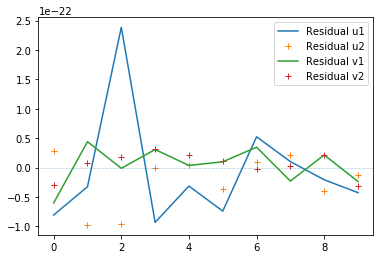

In [32]:
plt.plot((-ds['dudt']+ds['CAu']+ds['PFu']+ds['diffu']+ds['du_dt_visc']+ds['u_BT_accel']).mean(['xq','yh']).isel(zl=0),
         label='Residual u1')
plt.plot((-ds['dudt']+ds['CAu']+ds['PFu']+ds['diffu']+ds['du_dt_visc']+ds['u_BT_accel']).mean(['xq','yh']).isel(zl=1),
         '+', label='Residual u2')
plt.plot((-ds['dvdt']+ds['CAv']+ds['PFv']+ds['diffv']+ds['dv_dt_visc']+ds['v_BT_accel']).mean(['xh','yq']).isel(zl=0),
         label='Residual v1')
plt.plot((-ds['dvdt']+ds['CAv']+ds['PFv']+ds['diffv']+ds['dv_dt_visc']+ds['v_BT_accel']).mean(['xh','yq']).isel(zl=1),
         '+', label='Residual v2')
plt.axhline(y=0, ls=':',lw=0.5)
plt.legend()

$\large \text{Temporary Checks}$

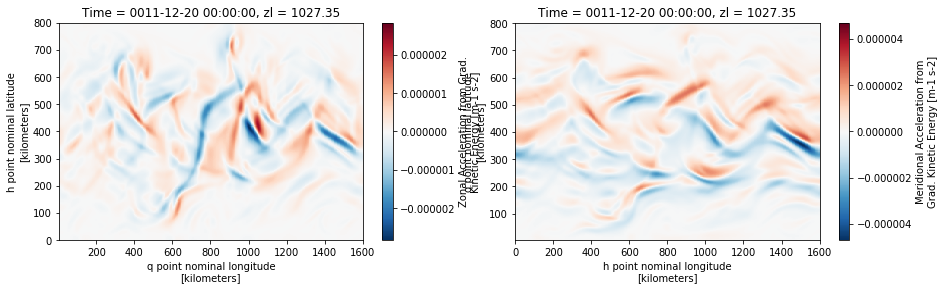

In [40]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
ds['gKEu'].isel(Time=idx, zl=0).plot()

plt.subplot(1,2,2)
ds['gKEv'].isel(Time=idx, zl=0).plot()

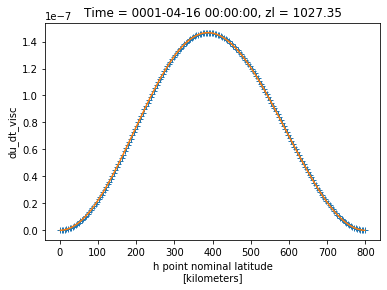

In [36]:
(ds['taux'].isel(Time=730).sum('xq')/(1027.35*ds['h'].sum('xh').isel(zl=0).isel(Time=10))).plot(linestyle=' ', marker='+')
ds['du_dt_visc'].isel(Time=10, zl=0).mean('xq').plot()

Text(0, 0.5, 'y (km)')

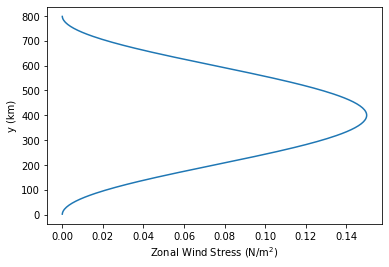

In [32]:
#ds['taux'].isel(Time=730).plot()
plt.plot(ds['taux'].isel(Time=10, xq=0), ds['yh'])
plt.xlabel('Zonal Wind Stress (N/m$^2$)')
plt.ylabel('y (km)')

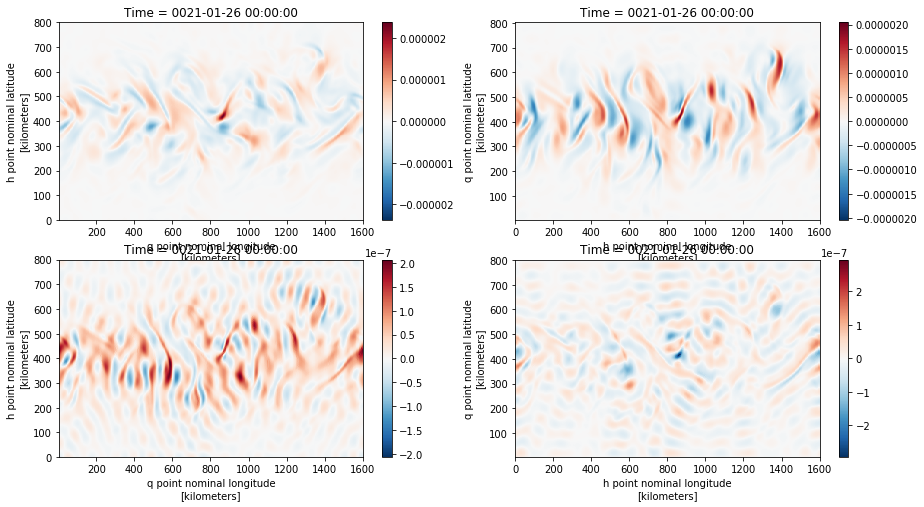

In [27]:
idx=5
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
(ds['ubt_dt'] -ds['u_accel_bt']).isel(Time=idx).plot()

plt.subplot(2,2,2)
(ds['vbt_dt'] -ds['v_accel_bt']).isel(Time=idx).plot()

plt.subplot(2,2,3)
(- ds['ubt_dt'] + ds['u_accel_bt'] + ds['ubtforce'] + ds['CoruBT'] + ds['PFuBT']).isel(Time=idx).plot()

plt.subplot(2,2,4)
(- ds['vbt_dt'] + ds['v_accel_bt'] + ds['vbtforce'] + ds['CorvBT'] + ds['PFvBT']).isel(Time=idx).plot()

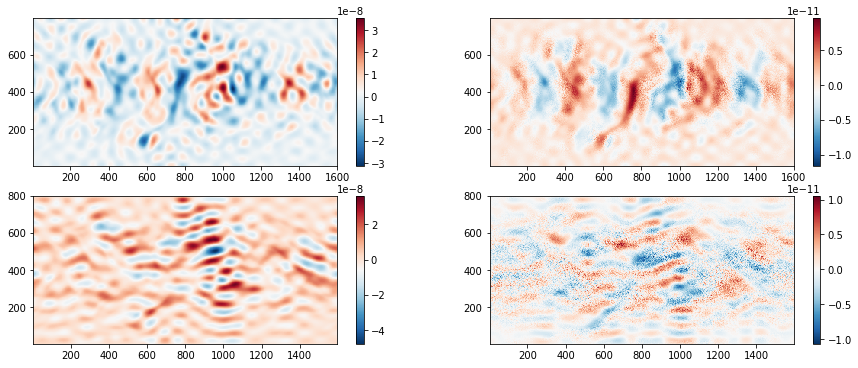

In [9]:
plt.figure(figsize=(15,6))

res_u = ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc'] 
res_v = ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc'] 

plt.subplot(2,2,1)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=400, zl=0), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=400, zl=0) - res_u.isel(Time=400, zl=1), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=400, zl=0), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=400, zl=0) - res_v.isel(Time=400, zl=1), cmap='RdBu_r')
plt.colorbar()


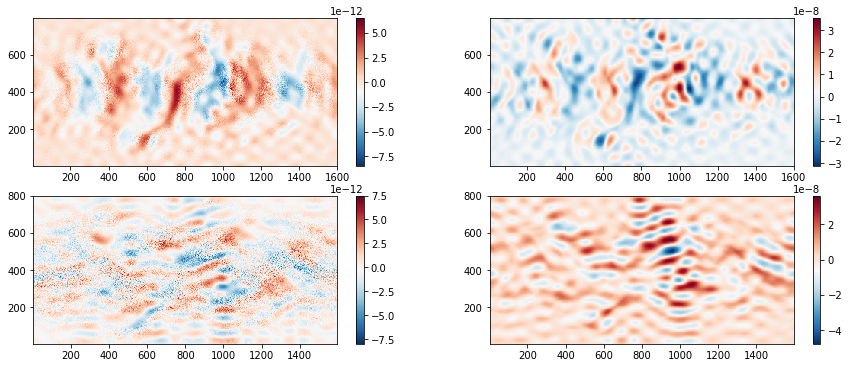

In [23]:
rhom = (rho[0]*1000. + rho[1]*3000.)/4000.

res_u = ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc'] 
res_v = ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc'] 

res1_u = ds['dudt']-ds['CAu']-ds['PFu']*rho[0]/rhom-ds['diffu']-ds['du_dt_visc'] 
res1_v = ds['dvdt']-ds['CAv']-ds['PFv']*rho[0]/rhom-ds['diffv']-ds['dv_dt_visc']

plt.figure(figsize=(15,6))

plt.subplot(2,2,1)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=400, zl=0) - ds['u_accel_bt'].isel(Time=400), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=400, zl=0), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=400, zl=0) - ds['v_accel_bt'].isel(Time=400), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=400, zl=0), cmap='RdBu_r')
plt.colorbar()

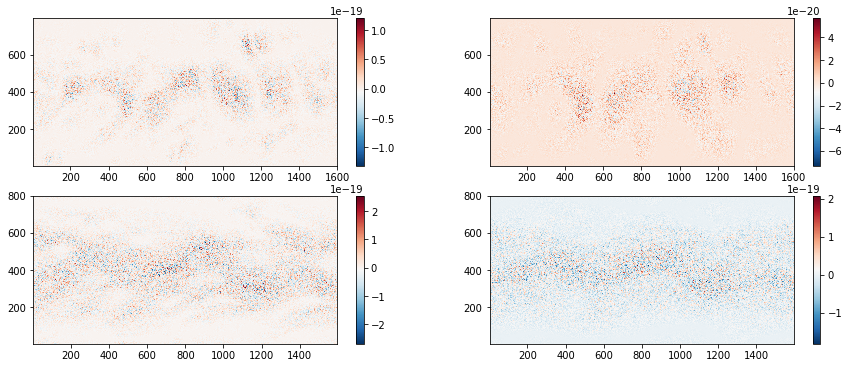

In [15]:
idx =8

res_u = ds['dudt']-ds['CAu']-ds['PFu']-ds['diffu']-ds['du_dt_visc'] - ds['u_BT_accel']
res_v = ds['dvdt']-ds['CAv']-ds['PFv']-ds['diffv']-ds['dv_dt_visc'] - ds['v_BT_accel']

plt.figure(figsize=(15,6))

plt.subplot(2,2,1)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=idx, zl=0), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(ds['xq'], ds['yh'], res_u.isel(Time=idx, zl=1), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=idx, zl=0), cmap='RdBu_r')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(ds['xh'], ds['yq'], res_v.isel(Time=idx, zl=1), cmap='RdBu_r')
plt.colorbar()

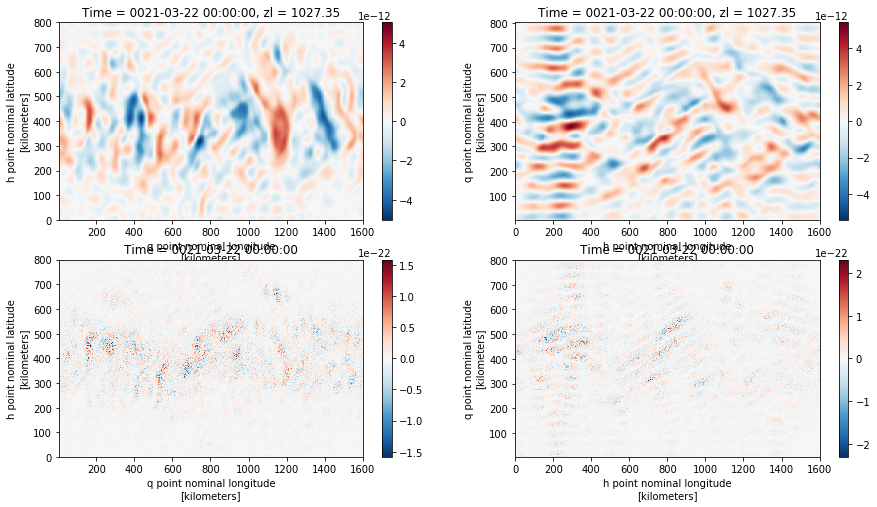

In [13]:
idx=8
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
(ds['u_BT_accel'].isel(zl=0) -ds['u_accel_bt']).isel(Time=idx).plot()

plt.subplot(2,2,2)
(ds['v_BT_accel'].isel(zl=0) -ds['v_accel_bt']).isel(Time=idx).plot()

plt.subplot(2,2,3)
(-ds['u_accel_bt'] +ds['CoruBT'] + ds['PFuBT']).isel(Time=idx).plot()

plt.subplot(2,2,4)
(-ds['v_accel_bt'] + ds['CorvBT'] + ds['PFvBT']).isel(Time=idx).plot()

In [13]:
rhom = (rho[0]*1000. + rho[1]*3000.)/4000.
rhom

1027.7690644515305

# KE budget

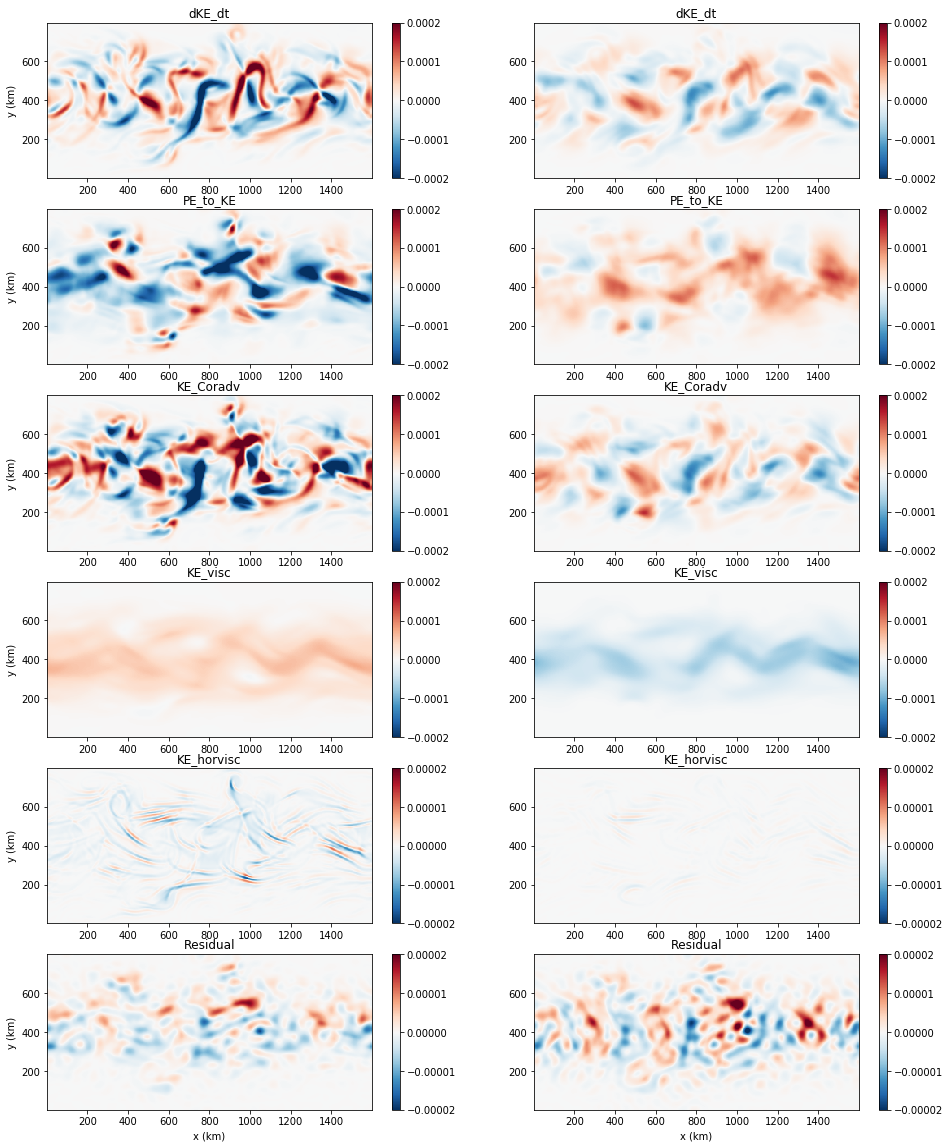

In [23]:
idx = 400
plt.figure(figsize=(16,20))
max_r = 2.e-4

for i in range(0,2):
    plt.subplot(6,2, i+1)
    plt.pcolormesh(ds['xh'], ds['yh'], ds['dKE_dt'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='RdBu_r')
    plt.title('dKE_dt')
    plt.colorbar()
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(6,2, i+3)
    plt.pcolormesh(ds['xh'], ds['yh'], ds['PE_to_KE'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='RdBu_r')
    plt.title('PE_to_KE')
    plt.colorbar()
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(6,2, i+5)
    plt.pcolormesh(ds['xh'], ds['yh'], ds['KE_Coradv'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='RdBu_r')
    plt.title('KE_Coradv')
    plt.colorbar()
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(6,2, i+7)
    plt.pcolormesh(ds['xh'], ds['yh'], ds['KE_visc'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='RdBu_r')
    plt.title('KE_visc')
    plt.colorbar()
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(6,2, i+9)
    plt.pcolormesh(ds['xh'], ds['yh'], ds['KE_horvisc'].isel(Time=idx, zl=i), vmin = -1e-1*max_r, 
             vmax = 1e-1*max_r, cmap='RdBu_r')
    plt.title('KE_horvisc')
    plt.colorbar()
    if(i==0):
        plt.ylabel('y (km)')
        
    res = ds['dKE_dt'] - ds['PE_to_KE'] - ds['KE_Coradv'] - ds['KE_visc'] - ds['KE_horvisc']    
    plt.subplot(6,2, i+11)
    plt.pcolormesh(ds['xh'], ds['yh'], res.isel(Time=idx, zl=i), vmin = -1e-1*max_r, 
             vmax = 1e-1*max_r, cmap='RdBu_r')
    plt.title('Residual')
    plt.colorbar()
    plt.xlabel('x (km)')
    if(i==0):
        plt.ylabel('y (km)')
    

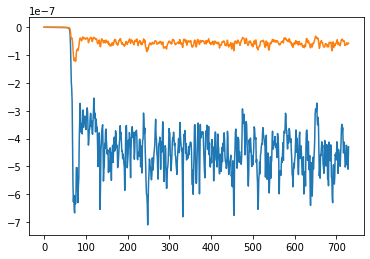

In [22]:
plt.plot(ds['KE_horvisc'].mean(['xh','yh']))

In [22]:
ds.close()
client.close()
cluster.close()